In [1]:
import random

import pandas as pd
import numpy as np 
from scipy.special import softmax
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, classification_report, 
                             confusion_matrix)
import tensorflow as tf
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification
from transformers import AutoConfig


## Data Loading

In [2]:

train_data = pd.read_csv('../input/nlp-getting-started/train.csv')
print(train_data.shape)
train_data.head(10)

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


The training dataset includes a column `text` with the text we must classify and an additional column `target` which tells us if the tweet is about a real disaster (1-> real disaster). The test dataset looks similar.

In [3]:
# load test dataset
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')
print(test_data.shape)
test_data.head(10)

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [4]:
for tweet_index in range(1,30,5):
    print(f'Text of the tweet: {train_data["text"][tweet_index]}')
    print(f'Target: {"Real disaster" if train_data["target"][tweet_index]==1 else "Not real disaster"}\n')

Text of the tweet: Forest fire near La Ronge Sask. Canada
Target: Real disaster

Text of the tweet: #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
Target: Real disaster

Text of the tweet: Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
Target: Real disaster

Text of the tweet: I love fruits
Target: Not real disaster

Text of the tweet: London is cool ;)
Target: Not real disaster

Text of the tweet: Was in NYC last week!
Target: Not real disaster



/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target', ylabel='count'>

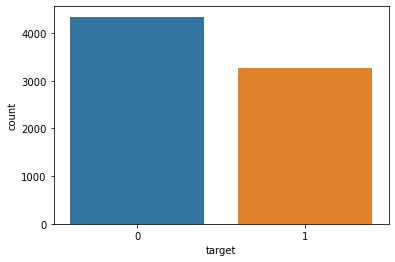

In [5]:
sns.countplot(train_data["target"])

In [11]:


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [12]:
def prepare_sequence(text):
    

    prepared_sequence = tokenizer.encode_plus(
                            text, 
                            add_special_tokens = True, 
                            max_length = 512, 
                            padding = 'max_length',
                            return_attention_mask = True
                            )
    return prepared_sequence

In [13]:
# Prepare a test sentence
test_sentence = 'Is this jacksonville?'
test_sentence_encoded = prepare_sequence(test_sentence)
token_ids = test_sentence_encoded["input_ids"]


## Data preparation

We build the training and validation datasets in the format expected by the `TFBertForSequenceClassification` model.

In [14]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
   
    mapped_example = {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_masks,
    }
    return mapped_example, label 

def encode_examples(texts_and_labels):
    """
    Prepare all sequences of text and build TF dataset.
    """

    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
        
    for text, label in texts_and_labels:

        bert_input = prepare_sequence(text)

        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])

    # Create TF dataset
    dataset = tf.data.Dataset.from_tensor_slices(
        (input_ids_list, attention_mask_list, token_type_ids_list,
         label_list)
    )
    # Map to the expected input to TFBertForSequenceClassification
    dataset_mapped = dataset.map(map_example_to_dict)
    return dataset_mapped

In [15]:
X = train_data["text"]
y = train_data["target"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, 
                                                    random_state=1)

In [16]:
n_training_examples = X_train.shape[0]
n_positive_training_examples = y_train.value_counts()[1]
n_negative_training_examples = y_train.value_counts()[0]
print(f'Number examples in training dataset: {n_training_examples}')
print(f'Number of positive examples in training dataset: {n_positive_training_examples}')
print(f'Number of negative examples in training dataset: {n_negative_training_examples}')

Number examples in training dataset: 6851
Number of positive examples in training dataset: 2947
Number of negative examples in training dataset: 3904


In [17]:
train_dataset = list(zip(X_train, y_train))
val_dataset = list(zip(X_val, y_val))

In [18]:
# Prepare sequences of text and build TF train dataset
ds_train_encoded = encode_examples(train_dataset).shuffle(10000).batch(20)

# Prepare sequences of text and build TF validation dataset
ds_val_encoded = encode_examples(val_dataset).batch(20)

## Model

In [19]:
def get_model():
    # Define the configuration of the model
    config = AutoConfig.from_pretrained('bert-base-uncased',
                                        hidden_dropout_prob=0.2,
                                        num_labels=2)
    # Model initialization
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                            config=config)
    return model

In [20]:
# Model initialization
model = get_model()

# Define the optimizer, the loss function and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Model training

In [21]:

weight_for_0 = (1 / n_negative_training_examples)*(n_training_examples)/2.0 
weight_for_1 = (1 / n_positive_training_examples)*(n_training_examples)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.88
Weight for class 1: 1.16


In [ ]:
# Train the model
model.fit(ds_train_encoded, epochs=10, validation_data=ds_val_encoded,
          class_weight = class_weight)

Epoch 1/10


## Model evaluation

In [ ]:

val_predictions = model.predict(ds_val_encoded)
val_probabilities = softmax(val_predictions[0], axis=1)
y_val_predictions = np.argmax(val_probabilities, axis=1).flatten()

In [ ]:

classification_metrics = classification_report(y_val, y_val_predictions)

area_under_the_curve = roc_auc_score(y_val, val_probabilities[:,1:2], multi_class="ovr")

error_matrix = confusion_matrix(y_val, y_val_predictions)
print(f'Area under the ROC curve: {area_under_the_curve}')
print(f'Classification metrics:\n{classification_metrics}')

ax = plt.axes()
sns.heatmap(error_matrix, annot=True, fmt="d")
ax.set_title('Confusion matrix Validation set')

In [ ]:
def encode_test_examples(texts):
    """
    Prepare all sequences of text and build TF dataset.
    """

    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
        
    for text in texts:

        bert_input = prepare_sequence(text)

        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])

    # Create TF dataset
    dataset = tf.data.Dataset.from_tensor_slices(
        (input_ids_list, attention_mask_list, token_type_ids_list)
    )
    # Map to the expected input to TFBertForSequenceClassification
    dataset_mapped = dataset.map(map_test_example_to_dict)
    return dataset_mapped

def map_test_example_to_dict(input_ids, attention_masks, token_type_ids):
    
    mapped_example = {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_masks,
    }
    return mapped_example

In [ ]:
X_test = test_data["text"]
test_dataset = list(X_test)
ds_test_encoded = encode_test_examples(test_dataset).batch(20)

In [ ]:
test_predictions = model.predict(ds_test_encoded)
test_probabilities = softmax(test_predictions[0], axis=1)
y_test_predictions = np.argmax(test_probabilities, axis=1).flatten()

In [ ]:
# Copy the results to a pandas dataframe with an "id" column and a "target" column
final_submission = pd.DataFrame( data={"id":test_data["id"], "target":y_test_predictions})
# Save the submission file
final_submission.to_csv("submissionTweets.csv", index=False)